# Part 7.2 - Sentiment Analysis on Topic Modeling
---

### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import conf_pyspark, load_dataset
from utils_preplot import load_doctopic
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline
dpi=80

import datetime
print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

from sklearn.preprocessing import MinMaxScaler
import textblob as tb

from pyspark.sql import functions as F
from pyspark.sql.types import *

# intiate PySpark
sc, spark = conf_pyspark()

sc

2019-02-03 19:14:00
[('spark.driver.host', 'x99.hub'),
 ('spark.app.name', 'local'),
 ('spark.app.id', 'local-1549174442997'),
 ('spark.driver.maxResultSize', '8g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.memory', '62g'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '37037'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.cores', '6')]


<SparkContext master=local[*] appName=local>

**Did people live with happyness or not? In this part we will apply a sentiment analysis process to topics to find the answer.**

**We consider each topic has a score of sentiment more or less, we can use a sentiment tool (TextBlob) to get the score. Then we multiply the score of each topic to the corresponding topic weight in average weight-year matrix, we get the sentiment-year matrix. This matrix is the answer of the question.**

## 1 Load Data

**Load metadata:**

In [2]:
df_meta = load_dataset('meta', spark).select(F.col('id').alias('id_'), F.col('region'), F.col('date'))
df_meta.cache()

DataFrame[id_: int, region: string, date: date]

In [3]:
df_meta.limit(5).toPandas().head()

,id_,region,date
0,1854213,Auckland,1862-06-14
1,1854215,Auckland,1862-06-14
2,1854221,Auckland,1862-06-14
3,1854224,Auckland,1862-07-03
4,1854232,Auckland,1863-08-01


**Topic List:**

In [4]:
path = r'../models/train/topicKeys.txt'

df_topics = (pd.read_table(path, 
                           header=None, 
                           index_col=None, 
                           names = ['topic', 'weight', 'keywords'],
                           encoding='utf8')
             .sort_values(by='topic')
             .reset_index(drop=True))

topics_shape = df_topics.shape
topic_number = df_topics.shape[0]

print('Shape of dataframe:', topics_shape)
df_topics.sample(5)

Shape of dataframe: (200, 3)


,topic,weight,keywords
1,1,0.01074,prices advertisements column suit latest ladies suits made street quality goods good wear style special styles fit c...
181,181,0.00705,miles river island country lake expedition water found party north south sea great coast feet land mountain made wes...
158,158,0.00872,land country colony new_zealand great people large government population years settlement present settlers system st...
84,84,0.01590,letter sir editor public paper matter made statement time letters times question published issue correspondent fact ...
164,164,0.00816,election candidate electors party vote candidates votes labour elections seat elected majority political liberal pol...


**Load doc-topic matrix:**

In [5]:
path = r'../models/train/docTopics.txt'

df_doctopic = (load_doctopic(path, topics_shape[0], spark)).drop('index').orderBy('id')
df_doctopic.cache();

In [6]:
print('Shape of dataframe:({}, {})'.format(df_doctopic.count(), len(df_doctopic.columns)))
df_doctopic.limit(5).toPandas().head()

Shape of dataframe:(3025602, 201)


,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1854213,0.000196,0.000321,0.777824,0.000115,0.000269,0.000154,0.000291,0.000227,0.000227,0.000143,0.000254,0.000210,0.000139,0.000235,0.000221,0.000279,0.000245,0.000247,0.000178,0.000305,0.000135,0.090193,0.000215,0.000042,0.000103,0.000260,0.000069,0.000106,0.000294,0.000197,0.000227,0.000176,0.000121,0.031044,0.000048,0.000190,0.000268,0.000177,0.000158,0.000230,0.000169,0.000165,0.000215,0.000315,0.000183,0.000184,0.000214,0.000159,0.000065,0.000088,0.000263,0.000187,0.000139,0.000104,0.000165,0.000172,0.000155,0.000288,0.000312,...,0.000170,0.000325,0.000338,0.000191,0.000035,0.000223,0.000237,0.000350,0.000084,0.000255,0.000391,0.000196,0.000191,0.000165,0.000213,0.000213,0.000292,0.000288,0.000261,0.000406,0.000239,0.000134,0.000109,0.000175,0.000244,0.000219,0.000119,0.000173,0.000272,0.000128,0.000257,0.000112,0.000072,0.000100,0.000155,0.000189,0.000134,0.000111,0.000168,0.000158,0.000222,0.000211,0.000307,0.000206,0.000256,0.000198,0.000159,0.000438,0.000215,0.000215,0.000269,0.000322,0.000177,0.000282,0.000290,0.000466,0.000188,0.000201,0.000230,0.000148
1,1854215,0.000112,0.000184,0.000379,0.000066,0.000154,0.000088,0.000166,0.000130,0.102773,0.000082,0.000146,0.000120,0.000080,0.000135,0.000126,0.000160,0.000140,0.000141,0.000102,0.000174,0.000077,0.000298,0.000123,0.000024,0.000059,0.000149,0.000040,0.000061,0.000168,0.000113,0.000130,0.000101,0.000069,0.034874,0.000028,0.000109,0.000153,0.000101,0.000091,0.000131,0.000097,0.000095,0.000123,0.000180,0.000104,0.000106,0.000123,0.000091,0.000037,0.000050,0.000151,0.000107,0.000080,0.000060,0.000094,0.000098,0.000089,0.000165,0.000178,...,0.000097,0.000186,0.000193,0.000109,0.000020,0.000128,0.000135,0.000200,0.000048,0.000146,0.000224,0.000112,0.000109,0.000094,0.000122,0.325158,0.000167,0.000165,0.000149,0.000232,0.000137,0.000077,0.000062,0.000100,0.000140,0.000125,0.000068,0.000099,0.000156,0.000073,0.000147,0.000064,0.000041,0.000057,0.000089,0.000108,0.000077,0.000064,0.000096,0.000090,0.000127,0.000121,0.000176,0.000118,0.000147,0.000113,0.000091,0.000251,0.000123,0.000123,0.000154,0.000184,0.051423,0.000161,0.000166,0.000267,0.000108,0.000115,0.000131,0.000085
2,1854221,0.000158,0.000259,0.000534,0.000093,0.000217,0.000124,0.000234,0.000184,0.000183,0.000116,0.000205,0.000169,0.000112,0.000190,0.000178,0.000225,0.000198,0.000199,0.000144,0.000246,0.000109,0.000420,0.000173,0.000034,0.000083,0.000210,0.000056,0.000086,0.000237,0.000159,0.000183,0.000142,0.000098,0.025053,0.000039,0.000154,0.000216,0.892676,0.000128,0.000185,0.000137,0.000133,0.000173,0.000254,0.000147,0.000149,0.000173,0.000128,0.000052,0.000071,0.000213,0.000151,0.000112,0.000084,0.000133,0.000139,0.000125,0.000233,0.000252,...,0.000137,0.000263,0.000273,0.000154,0.000028,0.000180,0.000191,0.000282,0.000068,0.000206,0.000316,0.000158,0.000154,0.000133,0.000172,0.000172,0.000236,0.000232,0.000210,0.024450,0.000193,0.000108,0.000088,0.000141,0.000197,0.000177,0.000096,0.000139,0.000220,0.000103,0.000208,0.000091,0.000058,0.000081,0.000125,0.000153,0.000108,0.000090,0.000136,0.000127,0.000179,0.000170,0.000248,0.000166,0.000207,0.000159,0.000129,0.000354,0.000174,0.000174,0.000217,0.000260,0.000143,0.000228,0.000234,0.000376,0.000152,0.000162,0.000185,0.000120
3,1854224,0.000148,0.000242,0.000498,0.000086,0.000203,0.000116,0.000219,0.000171,0.000171,0.000108,0.000191,0.000158,0.000105,0.000177,0.000166,0.000210,0.000185,0.000186,0.000134,0.000229,0.000102,0.000391,0.000161,0.000032,0.000077,0.000196,0.000052,0.000080,0.000221,0.000148,0.000171,0.000133,0.000091,0.000868,0.000036,0.000

## 2 Generate Dataset

**We need to generate average-weight-year matrix for analysis.**

In [7]:
# doc-weight-year matrix
df = (df_doctopic
      .join(df_meta, df_doctopic.id == df_meta.id_)
      .withColumn('year', F.date_format('date', 'yyyy'))
      .drop('id')
      .drop('id_')
      .drop('region')
      .drop('date')
      .orderBy('year')
      )

# avg-weight-year matrix
df = (df
      .groupBy('year')
      .avg()
      .orderBy('year'))

df = df.toPandas()

columns = [str(x) for x in list(range(topic_number))]
columns.insert(0, 'year')
df.columns = columns

print('Shape of dataframe:', df.shape)
df.head()

Shape of dataframe: (104, 201)


,year,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1839,0.000022,0.000425,0.000911,0.000013,0.000030,0.000017,0.000032,0.000025,0.000025,0.000016,0.005481,0.000023,0.019074,0.023314,0.000024,0.032158,0.000027,0.019974,0.003910,0.007707,0.000015,0.007991,0.000024,0.000005,0.000011,0.000029,0.000008,0.000012,0.000032,0.000022,0.000025,0.000019,0.000013,0.001686,0.000005,0.000021,0.000029,0.000019,0.000017,0.000025,0.209892,0.000018,0.000024,0.000035,0.000020,0.007599,0.000024,0.000017,0.000007,0.000010,0.000029,0.000021,0.000405,0.001308,0.009868,0.000019,0.000017,0.000032,0.000034,...,0.000019,0.000036,0.000037,0.000021,0.000004,0.000025,0.000026,0.000039,0.000009,0.000028,0.010118,0.003396,0.000021,0.004306,0.000023,0.000023,0.000032,0.000032,0.136809,0.000045,0.000026,0.000015,0.000012,0.000019,0.000027,0.000024,0.000013,0.015223,0.003056,0.000014,0.000028,0.000012,0.000008,0.025350,0.000017,0.000112,0.000015,0.000012,0.029783,0.001577,0.000024,0.006863,0.000034,0.000411,0.000028,0.000022,0.000109,0.000048,0.000024,0.000024,0.010837,0.026408,0.000020,0.000923,0.023499,0.000051,0.007499,0.000022,0.000025,0.000016
1,1840,0.000081,0.000503,0.001999,0.000763,0.004680,0.001690,0.000216,0.001819,0.001664,0.000117,0.001402,0.000229,0.010482,0.007267,0.001201,0.000782,0.001086,0.002136,0.002577,0.021677,0.000285,0.025133,0.002325,0.000017,0.000120,0.003099,0.000028,0.000191,0.002528,0.001410,0.000093,0.003402,0.013162,0.105065,0.000217,0.001906,0.001721,0.000089,0.000471,0.006302,0.056248,0.000068,0.001125,0.001421,0.004782,0.000633,0.003048,0.000065,0.000242,0.000036,0.001449,0.000512,0.000172,0.098555,0.001812,0.000184,0.000128,0.010088,0.001764,...,0.000143,0.002829,0.000777,0.000564,0.000014,0.006599,0.004181,0.000500,0.000114,0.000322,0.001695,0.013306,0.000079,0.000376,0.000150,0.023368,0.000266,0.005717,0.038471,0.000357,0.000228,0.000098,0.000045,0.000835,0.001051,0.000090,0.000068,0.001377,0.000706,0.000118,0.001322,0.000046,0.000030,0.002334,0.002351,0.002608,0.000969,0.000252,0.003852,0.031229,0.000408,0.023364,0.004443,0.000268,0.000856,0.000670,0.000858,0.002600,0.000283,0.000610,0.001118,0.011030,0.001954,0.001597,0.002822,0.001108,0.007900,0.009607,0.000282,0.000061
2,1841,0.000270,0.000333,0.004577,0.000861,0.001153,0.000425,0.000303,0.000698,0.005899,0.000220,0.002391,0.001761,0.010938,0.003140,0.000447,0.001302,0.000389,0.003336,0.002409,0.012347,0.004211,0.016922,0.000690,0.000019,0.000382,0.001464,0.000304,0.000289,0.002560,0.001814,0.000182,0.004298,0.046995,0.007275,0.000035,0.001499,0.000471,0.002161,0.000312,0.002897,0.044117,0.000143,0.001276,0.003230,0.001671,0.002199,0.005198,0.000568,0.000043,0.000164,0.001202,0.000159,0.000383,0.073176,0.001844,0.000078,0.000071,0.002074,0.001622,...,0.000078,0.000325,0.004013,0.000300,0.000016,0.001277,0.002131,0.000712,0.000067,0.000205,0.002044,0.006398,0.000896,0.000227,0.000356,0.004799,0.000206,0.005139,0.043389,0.000520,0.001673,0.000085,0.000050,0.005762,0.000430,0.000537,0.000138,0.001076,0.000491,0.003100,0.001666,0.001085,0.000041,0.000558,0.000144,0.001014,0.001432,0.000748,0.007553,0.042775,0.000790,0.012113,0.018435,0.000227,0.000562,0.004938,0.003222,0.014271,0.001089,0.004291,0.000405,0.004388,0.003445,0.000128,0.001500,0.000811,0.017527,0.014320,0.000203,0.000661
3,1842,0.000472,0.000590,0.007803,0.004253,0.002530,0.002092,0.000217,0.002493,0.010641,0.000564,0.000672,0.001531,0.006869,0.002314,0.003793,0.001777,0.001201,0.001987,0.003201,0.011118,0.005369,0.038392,0.000616,0.000012,0.000038,0.007703,0.000279,0.000134,0.007048,0.001169,0.001168,0.001784,0.007065,0.003125,0.000014,0.005702,0.0008

## 3 Topics Sentiment Analysis

**Use some sentences to check the sentiment analysis result:**

In [8]:
text = []
text.append('I am very happy today!')
text.append('The sun rises every day.')
text.append('He was badly wounded on the battlefield.')

for i in range(len(text)):
    t = tb.TextBlob(text[i])
    print('\nText:', text[i])
    print('Polarity = ', t.sentiment.polarity)
    print('Subjectivity = ', t.sentiment.subjectivity)


Text: I am very happy today!
Polarity =  1.0
Subjectivity =  1.0

Text: The sun rises every day.
Polarity =  0.0
Subjectivity =  0.0

Text: He was badly wounded on the battlefield.
Polarity =  -0.6999999999999998
Subjectivity =  0.6666666666666666


**We see the results of sentiment analysis make sense. Now we apply the process to each topic in topic list.**

In [9]:
df_score = df_topics.drop(columns='weight')

df_score['score'] = df_score['keywords'].apply(lambda x: tb.TextBlob(x).sentiment.polarity)

# scale score to 0 - 1
scaler = MinMaxScaler()
df_score['scaled'] = scaler.fit_transform(df_score[['score']])

df_score = df_score[['topic', 'score', 'scaled', 'keywords']]

df_score.head(10)

,topic,score,scaled,keywords
0,0,0.357143,0.704762,train railway leave trains station passengers return dep day tickets service stations express run railways fares spe...
1,1,0.489286,0.792857,prices advertisements column suit latest ladies suits made street quality goods good wear style special styles fit c...
2,2,0.294048,0.662698,time good year made great present work years fact number past season week large make place success doubt interest ago
3,3,0.000000,0.466667,plaintiff defendant claim court costs judgment case witness evidence paid amount pay appeared gave made plaintiffs c...
4,4,-0.200000,0.333333,found death body deceased man inquest dead named evidence witness died suicide morning murder wife returned house ve...
5,5,0.700000,0.933333,sale harness horses horse draught farm cows stock good cattle mare dairy plough sell cart years spring gelding instr...
6,6,0.700000,0.933333,motor masterton street car cycle phone cars prices advertisements tyres column price cycles good agents call stock g...
7,7,0.000000,0.466667,board committee meeting chairman report received messrs letter resolved present held read decided matter reported mo...
8,8,0.214286,0.609524,goods books fancy christmas stock cases large sets presents xmas assortment cards prices toys variety boxes statione...
9,9,0.130000,0.553333,hotel proprietor house accommodation rooms hot private visitors mrs day tariff baths moderate telephone good late st...


**The sorce looks not very coincident with our own feel, which should be caused by multiple reasons (we are not very clear now), take it as future work.**

**Then we multiply each average topic weight with it's sentiment score, get the sentiment-year matrix.**

In [10]:
score_list = df_score.scaled.tolist()

for i in range(len(score_list)):
    df[df.columns[i+1]] = df[df.columns[i+1]] * score_list[i]

df.head()

,year,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1839,0.000015,0.000337,0.000604,0.000006,0.000010,0.000016,0.000030,0.000012,0.000015,0.000009,0.004020,0.000008,0.008901,0.010880,0.000011,0.018759,0.000013,0.009321,0.001825,0.003597,0.000006,0.005727,0.000011,0.000003,0.000005,0.000012,0.000007,0.000009,0.000015,0.000008,0.000016,0.000014,0.000006,0.000225,0.000004,0.000010,0.000010,0.000016,0.000012,0.000020,0.100282,0.000010,0.000011,0.000024,0.000013,0.004632,0.000022,0.000008,0.000005,0.000009,0.000011,0.000009,0.000247,0.000611,0.004605,0.000009,0.000014,0.000015,0.000016,...,0.000009,0.000027,0.000017,0.000010,0.000002,0.000011,0.000012,0.000021,0.000004,0.000013,0.004722,0.001585,0.000012,0.002727,0.000011,0.000008,0.000015,0.000032,0.094681,0.000020,0.000011,0.000007,0.000007,0.000010,0.000013,0.000011,0.000007,0.009279,0.001426,0.000007,0.000021,0.000012,0.000003,0.014084,0.000007,0.000065,0.000007,0.000005,0.013899,0.000972,0.000011,0.006863,0.000016,0.000192,0.000009,0.000010,0.000051,0.000023,0.000013,0.000011,0.006213,0.013875,0.000011,0.000485,0.013107,0.000040,0.003499,0.000011,0.000008,0.000008
1,1840,0.000057,0.000399,0.001325,0.000356,0.001560,0.001577,0.000201,0.000849,0.001014,0.000065,0.001028,0.000082,0.004892,0.003391,0.000560,0.000456,0.000507,0.000997,0.001203,0.010116,0.000121,0.018012,0.001085,0.000011,0.000048,0.001317,0.000027,0.000153,0.001180,0.000525,0.000058,0.002523,0.006142,0.014009,0.000155,0.000889,0.000574,0.000072,0.000330,0.005041,0.026874,0.000039,0.000525,0.000991,0.002975,0.000386,0.002845,0.000031,0.000169,0.000034,0.000531,0.000235,0.000105,0.045992,0.000846,0.000086,0.000107,0.004708,0.000823,...,0.000067,0.002169,0.000362,0.000263,0.000009,0.003080,0.001951,0.000267,0.000053,0.000150,0.000791,0.006209,0.000043,0.000238,0.000070,0.007789,0.000124,0.005717,0.026624,0.000161,0.000095,0.000045,0.000025,0.000446,0.000508,0.000042,0.000034,0.000839,0.000329,0.000055,0.000970,0.000043,0.000011,0.001297,0.000950,0.001507,0.000452,0.000112,0.001798,0.019258,0.000177,0.023364,0.002073,0.000125,0.000285,0.000313,0.000400,0.001213,0.000157,0.000285,0.000641,0.005795,0.001052,0.000839,0.001574,0.000874,0.003687,0.004560,0.000094,0.000028
2,1841,0.000190,0.000264,0.003033,0.000402,0.000384,0.000397,0.000283,0.000326,0.003596,0.000122,0.001754,0.000626,0.005105,0.001465,0.000209,0.000760,0.000182,0.001557,0.001124,0.005762,0.001790,0.012127,0.000322,0.000012,0.000153,0.000622,0.000284,0.000231,0.001195,0.000675,0.000114,0.003188,0.021931,0.000970,0.000025,0.000700,0.000157,0.001739,0.000218,0.002318,0.021078,0.000081,0.000595,0.002254,0.001040,0.001341,0.004851,0.000265,0.000030,0.000153,0.000441,0.000073,0.000234,0.034149,0.000860,0.000037,0.000059,0.000968,0.000757,...,0.000036,0.000249,0.001873,0.000140,0.000010,0.000596,0.000994,0.000380,0.000031,0.000096,0.000954,0.002986,0.000490,0.000144,0.000166,0.001600,0.000096,0.005139,0.030028,0.000234,0.000701,0.000039,0.000028,0.003073,0.000208,0.000250,0.000069,0.000656,0.000229,0.001447,0.001222,0.001012,0.000015,0.000310,0.000058,0.000586,0.000668,0.000331,0.003525,0.026378,0.000342,0.012113,0.008603,0.000106,0.000187,0.002304,0.001503,0.006660,0.000605,0.002002,0.000232,0.002305,0.001854,0.000067,0.000837,0.000640,0.008179,0.006796,0.000068,0.000309
3,1842,0.000332,0.000468,0.005171,0.001985,0.000843,0.001953,0.000202,0.001164,0.006486,0.000312,0.000493,0.000544,0.003205,0.001080,0.001770,0.001036,0.000560,0.000927,0.001494,0.005189,0.002282,0.027514,0.000288,0.000008,0.000015,0.003274,0.000260,0.000107,0.003289,0.000435,0.000729,0.001323,0.003297,0.000417,0.000010,0.002661,0.0002

**The sum of each row is the overall sentiment score of each year.**

In [11]:
# sum each year
df['score'] = df.iloc[:, 1:].sum(axis=1)

# scale score to emplify the difference of each year
scaler = MinMaxScaler()
df['scaled'] = scaler.fit_transform(df[['score']])

df.head()

,year,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,score,scaled
0,1839,0.000015,0.000337,0.000604,0.000006,0.000010,0.000016,0.000030,0.000012,0.000015,0.000009,0.004020,0.000008,0.008901,0.010880,0.000011,0.018759,0.000013,0.009321,0.001825,0.003597,0.000006,0.005727,0.000011,0.000003,0.000005,0.000012,0.000007,0.000009,0.000015,0.000008,0.000016,0.000014,0.000006,0.000225,0.000004,0.000010,0.000010,0.000016,0.000012,0.000020,0.100282,0.000010,0.000011,0.000024,0.000013,0.004632,0.000022,0.000008,0.000005,0.000009,0.000011,0.000009,0.000247,0.000611,0.004605,0.000009,0.000014,0.000015,0.000016,...,0.000017,0.000010,0.000002,0.000011,0.000012,0.000021,0.000004,0.000013,0.004722,0.001585,0.000012,0.002727,0.000011,0.000008,0.000015,0.000032,0.094681,0.000020,0.000011,0.000007,0.000007,0.000010,0.000013,0.000011,0.000007,0.009279,0.001426,0.000007,0.000021,0.000012,0.000003,0.014084,0.000007,0.000065,0.000007,0.000005,0.013899,0.000972,0.000011,0.006863,0.000016,0.000192,0.000009,0.000010,0.000051,0.000023,0.000013,0.000011,0.006213,0.013875,0.000011,0.000485,0.013107,0.000040,0.003499,0.000011,0.000008,0.000008,0.526270,0.528018
1,1840,0.000057,0.000399,0.001325,0.000356,0.001560,0.001577,0.000201,0.000849,0.001014,0.000065,0.001028,0.000082,0.004892,0.003391,0.000560,0.000456,0.000507,0.000997,0.001203,0.010116,0.000121,0.018012,0.001085,0.000011,0.000048,0.001317,0.000027,0.000153,0.001180,0.000525,0.000058,0.002523,0.006142,0.014009,0.000155,0.000889,0.000574,0.000072,0.000330,0.005041,0.026874,0.000039,0.000525,0.000991,0.002975,0.000386,0.002845,0.000031,0.000169,0.000034,0.000531,0.000235,0.000105,0.045992,0.000846,0.000086,0.000107,0.004708,0.000823,...,0.000362,0.000263,0.000009,0.003080,0.001951,0.000267,0.000053,0.000150,0.000791,0.006209,0.000043,0.000238,0.000070,0.007789,0.000124,0.005717,0.026624,0.000161,0.000095,0.000045,0.000025,0.000446,0.000508,0.000042,0.000034,0.000839,0.000329,0.000055,0.000970,0.000043,0.000011,0.001297,0.000950,0.001507,0.000452,0.000112,0.001798,0.019258,0.000177,0.023364,0.002073,0.000125,0.000285,0.000313,0.000400,0.001213,0.000157,0.000285,0.000641,0.005795,0.001052,0.000839,0.001574,0.000874,0.003687,0.004560,0.000094,0.000028,0.486964,0.000000
2,1841,0.000190,0.000264,0.003033,0.000402,0.000384,0.000397,0.000283,0.000326,0.003596,0.000122,0.001754,0.000626,0.005105,0.001465,0.000209,0.000760,0.000182,0.001557,0.001124,0.005762,0.001790,0.012127,0.000322,0.000012,0.000153,0.000622,0.000284,0.000231,0.001195,0.000675,0.000114,0.003188,0.021931,0.000970,0.000025,0.000700,0.000157,0.001739,0.000218,0.002318,0.021078,0.000081,0.000595,0.002254,0.001040,0.001341,0.004851,0.000265,0.000030,0.000153,0.000441,0.000073,0.000234,0.034149,0.000860,0.000037,0.000059,0.000968,0.000757,...,0.001873,0.000140,0.000010,0.000596,0.000994,0.000380,0.000031,0.000096,0.000954,0.002986,0.000490,0.000144,0.000166,0.001600,0.000096,0.005139,0.030028,0.000234,0.000701,0.000039,0.000028,0.003073,0.000208,0.000250,0.000069,0.000656,0.000229,0.001447,0.001222,0.001012,0.000015,0.000310,0.000058,0.000586,0.000668,0.000331,0.003525,0.026378,0.000342,0.012113,0.008603,0.000106,0.000187,0.002304,0.001503,0.006660,0.000605,0.002002,0.000232,0.002305,0.001854,0.000067,0.000837,0.000640,0.008179,0.006796,0.000068,0.000309,0.539615,0.707290
3,1842,0.000332,0.000468,0.005171,0.001985,0.000843,0.001953,0.000202,0.001164,0.006486,0.000312,0.000493,0.000544,0.003205,0.001080,0.001770,0.001036,0.000560,0.000927,0.001494,0.005189,0.002282,0.027514,0.000288,0.000008,0.000015,0.003274,0.000260,0.000107,0.003289,0.000435,0.000729,0.001323,0.003297,0.000417,0.000010,0.002661,0

## 4 Sentiment Over Time

**Generate dataframe to plot:**

In [12]:
df_plt = df[['year', 'scaled']]

# convert dataframe to time series
df_plt.index = pd.to_datetime(df_plt['year'])
df_plt.drop(columns='year', inplace=True)

df_plt.T

year,1839-01-01 00:00:00,1840-01-01 00:00:00,1841-01-01 00:00:00,1842-01-01 00:00:00,1843-01-01 00:00:00,1844-01-01 00:00:00,1845-01-01 00:00:00,1846-01-01 00:00:00,1847-01-01 00:00:00,1848-01-01 00:00:00,1849-01-01 00:00:00,1850-01-01 00:00:00,1851-01-01 00:00:00,1852-01-01 00:00:00,1853-01-01 00:00:00,1854-01-01 00:00:00,1855-01-01 00:00:00,1856-01-01 00:00:00,1857-01-01 00:00:00,1858-01-01 00:00:00,1859-01-01 00:00:00,1860-01-01 00:00:00,1861-01-01 00:00:00,1862-01-01 00:00:00,1863-01-01 00:00:00,1864-01-01 00:00:00,1865-01-01 00:00:00,1866-01-01 00:00:00,1867-01-01 00:00:00,1868-01-01 00:00:00,1869-01-01 00:00:00,1870-01-01 00:00:00,1871-01-01 00:00:00,1872-01-01 00:00:00,1873-01-01 00:00:00,1874-01-01 00:00:00,1875-01-01 00:00:00,1876-01-01 00:00:00,1877-01-01 00:00:00,1878-01-01 00:00:00,1879-01-01 00:00:00,1880-01-01 00:00:00,1881-01-01 00:00:00,1882-01-01 00:00:00,1883-01-01 00:00:00,1884-01-01 00:00:00,1885-01-01 00:00:00,1886-01-01 00:00:00,1887-01-01 00:00:00,1888-01-01 00:00:00,1889-01-01 00:00:00,1890-01-01 00:00:00,1891-01-01 00:00:00,1892-01-01 00:00:00,1893-01-01 00:00:00,1894-01-01 00:00:00,1895-01-01 00:00:00,1896-01-01 00:00:00,1897-01-01 00:00:00,1898-01-01 00:00:00,1899-01-01 00:00:00,1900-01-01 00:00:00,1901-01-01 00:00:00,1902-01-01 00:00:00,1903-01-01 00:00:00,1907-01-01 00:00:00,1908-01-01 00:00:00,1909-01-01 00:00:00,1910-01-01 00:00:00,1911-01-01 00:00:00,1912-01-01 00:00:00,1913-01-01 00:00:00,1914-01-01 00:00:00,1915-01-01 00:00:00,1916-01-01 00:00:00,1917-01-01 00:00:00,1918-01-01 00:00:00,1919-01-01 00:00:00,1920-01-01 00:00:00,1921-01-01 00:00:00,1922-01-01 00:00:00,1923-01-01 00:00:00,1924-01-01 00:00:00,1925-01-01 00:00:00,1926-01-01 00:00:00,1927-01-01 00:00:00,1928-01-01 00:00:00,1929-01-01 00:00:00,1930-01-01 00:00:00,1931-01-01 00:00:00,1932-01-01 00:00:00,1933-01-01 00:00:00,1934-01-01 00:00:00,1935-01-01 00:00:00,1936-01-01 00:00:00,1937-01-01 00:00:00,1938-01-01 00:00:00,1939-01-01 00:00:00,1940-01-01 00:00:00,1941-01-01 00:00:00,1942-01-01 00:00:00,1943-01-01 00:00:00,1944-01-01 00:00:00,1945-01-01 00:00:00
scaled,0.528018,0.0,0.70729,1.0,0.838186,0.771595,0.602424,0.493131,0.538097,0.661759,0.713262,0.847669,0.963452,0.882005,0.819052,0.711239,0.855791,0.884365,0.672734,0.741459,0.722392,0.739424,0.761576,0.573903,0.528803,0.381556,0.460402,0.474202,0.477659,0.496835,0.498153,0.47136,0.4814,0.466055,0.372981,0.44256,0.449874,0.403462,0.443063,0.505461,0.405899,0.427725,0.359688,0.374222,0.351674,0.337385,0.382679,0.454102,0.476655,0.434247,0.444435,0.399122,0.447035,0.446907,0.408386,0.430237,0.407123,0.501123,0.54284,0.484763,0.473023,0.460844,0.512422,0.545486,0.569401,0.689102,0.605493,0.620102,0.648064,0.644283,0.599009,0.614158,0.582398,0.531576,0.597918,0.580263,0.60323,0.672631,0.772017,0.843063,0.770484,0.775742,0.776553,0.861521,0.870833,0.904902,0.831561,0.901147,0.732425,0.638856,0.619287,0.590488,0.604782,0.634243,0.64098,0.632837,0.574707,0.5807,0.565829,0.535285,0.477398,0.487599,0.49409,0.564647


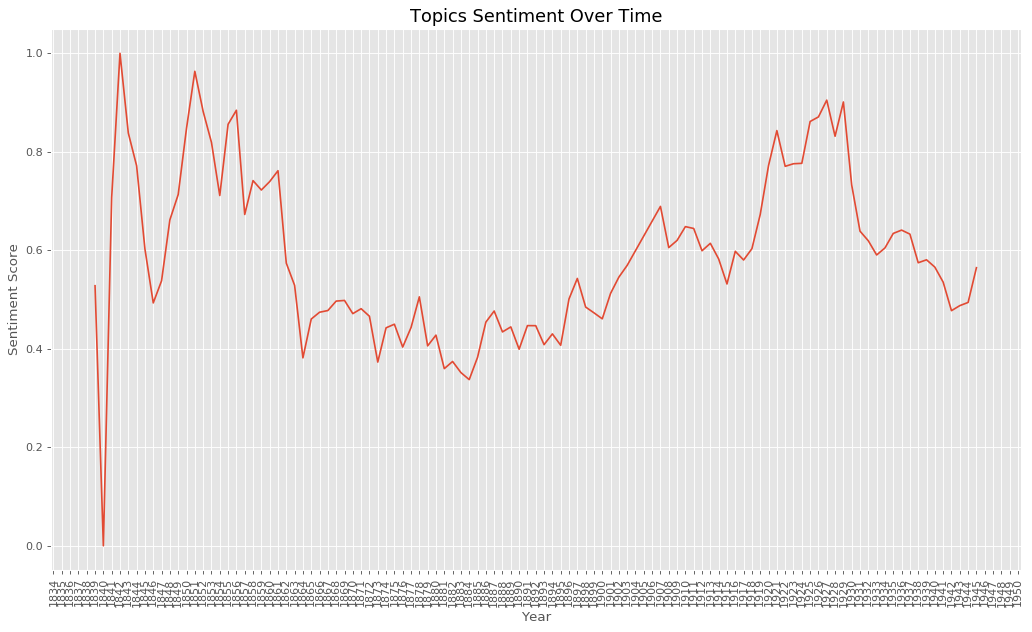

In [15]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=dpi)
year = mdates.YearLocator(month=1)
year_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

plt.plot_date(df_plt.index, df_plt['scaled'], '-')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title("Topics Sentiment Over Time", fontdict=dict(size=16))
plt.xticks(rotation='90')
plt.tight_layout()
plt.savefig('../temp/plot_sentiment.png')  
plt.show()  
plt.close()

**Although above process to generate sentiment based on topics are not very tight, it still display a reasonable answer for the question at the beginning. The first happy time begain in 1840 after The Treaty of Waitangi was assigned. The most happy period is after the WWI and drop quickly before the WWII.**

**The application of sentiment analysis on topic modeling is useful in historical research and social study.**

---

In [14]:
gc.collect()

15